<a href="https://colab.research.google.com/github/ghommidhWassim/GNN-variants/blob/main/nodeFeatCorrGCN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install torchvision
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.8.0+cu126.html




  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
2.8.0+cu126
12.6
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html


In [3]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd
import time
import json
# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
from torch_sparse import spmm
# import pyg_lib
import torch_sparse
from torch_geometric.utils import to_networkx
from sklearn.metrics import f1_score

# PyTorch geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid,Amazon
from torch_geometric.loader import ClusterData, ClusterLoader
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric import seed_everything
from torch.profiler import profile, record_function, ProfilerActivity
import os.path as osp
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GraphSAGE
from sklearn.metrics import accuracy_score
from transformers import AutoModelForCausalLM
from torch.profiler import profile, record_function, ProfilerActivity

In [5]:
def clean_gpu_memory():
    """Cleans GPU memory without fully resetting the CUDA context"""
    import gc
    gc.collect()  # Python garbage collection
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # PyTorch cache
        torch.cuda.reset_peak_memory_stats()  # Reset tracking
        print(f"Memory after cleanup: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

def f1_micro(data, mask):
    model.eval()
    out = model(data.x.to(device), data.edge_index.to(device))
    pred = out.argmax(dim=1)
    y_true = data.y[mask].cpu().numpy()
    y_pred = pred[mask.to(device)].cpu().numpy()
    return f1_score(y_true, y_pred, average='micro')


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Initial allocated memory: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

Initial allocated memory: 0.00 MB


In [ ]:
num_features, data, num_classes, device, dataset = dataset_load()
print(f'Number of nodes:          {data.num_nodes}')
print(f'Number of edges:          {data.num_edges}')
print(f'Average node degree:      {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes:       {data.has_isolated_nodes()}')
print(f'Has self-loops:           {data.has_self_loops()}')
print(f'Is undirected:            {data.is_undirected()}')

Using device: cuda


Processing...
Done!


Number of nodes:          19717
Number of edges:          88648
Average node degree:      4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes:       False
Has self-loops:           False
Is undirected:            True


In [5]:


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)


    def forward_layer1(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return x

    def forward_layer2(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)


In [6]:
def visualize_subgraph(x, edge_index, node_colors=None, title=None):
    G = to_networkx(Data(x=x, edge_index=edge_index), to_undirected=True)
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G, seed=42)  # You can change layout
    nx.draw(G, pos, with_labels=False, node_size=20, node_color='skyblue')
    plt.title(title or "Subgraph")
    plt.show()

In [6]:
import torch
from torch_geometric.utils import subgraph, to_networkx
from torch_geometric.data import Data
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
import random

def compute_corr_matrix(features):
    norm_features = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-8)
    return cosine_similarity(norm_features)

def drop_correlated_nodes(candidates, feature_matrix, threshold):
    if len(candidates) < 2:
        return candidates

    sub_feats = feature_matrix[candidates]
    corr_matrix = compute_corr_matrix(sub_feats)

    to_drop = set()
    for i in range(len(candidates)):
        for j in range(i + 1, len(candidates)):
            if corr_matrix[i][j] > threshold:
                drop_node = random.choice([candidates[i], candidates[j]])
                to_drop.add(drop_node)

    filtered = [n for n in candidates if n not in to_drop]
    return filtered

def custom_partition(data, num_subgraphs=128, similarity_threshold=0.7, nodes_per_subgraph=None):
    total_nodes = data.num_nodes
    if nodes_per_subgraph is None:
        nodes_per_subgraph = total_nodes // num_subgraphs

    all_nodes = set(range(total_nodes))
    used_nodes = set()
    subgraphs = []
    x_np = data.x.cpu().numpy()

    while len(used_nodes) < total_nodes and len(subgraphs) < num_subgraphs:
        candidate_nodes = list(all_nodes - used_nodes)
        if not candidate_nodes:
            break

        seed = np.random.choice(candidate_nodes)
        current_hop_nodes = [seed]
        selected_nodes = set([seed])
        visited = set([seed])

        while len(selected_nodes) < nodes_per_subgraph:
            neighbors = []
            for node in current_hop_nodes:
                neigh = data.edge_index[1][data.edge_index[0] == node].cpu().numpy()
                neighbors.extend(neigh.tolist())
            neighbors = list(set(neighbors) - used_nodes - selected_nodes)

            if not neighbors:
                break

            # Drop correlated neighbors based on cosine similarity
            filtered_neighbors = drop_correlated_nodes(neighbors, x_np, threshold=similarity_threshold)

            if not filtered_neighbors:
                break

            for n in filtered_neighbors:
                if len(selected_nodes) >= nodes_per_subgraph:
                    break
                if n not in visited:
                    selected_nodes.add(n)
                    visited.add(n)

            current_hop_nodes = filtered_neighbors

        used_nodes.update(selected_nodes)

        sub_nodes = list(selected_nodes)
        edge_index_sub, _ = subgraph(sub_nodes, data.edge_index, relabel_nodes=True, num_nodes=total_nodes)
        x_sub = data.x[sub_nodes]
        y_sub = data.y[sub_nodes]
        mask_sub = {}
        for key in ['train_mask', 'val_mask', 'test_mask']:
            if hasattr(data, key):
                mask = getattr(data, key)
                mask_sub[key] = mask[sub_nodes]

        subgraph_data = Data(x=x_sub, edge_index=edge_index_sub, y=y_sub, **mask_sub)
        subgraphs.append(subgraph_data)

        #visualize_subgraph(x_sub, edge_index_sub, title=f"Subgraph #{len(subgraphs)}")

    return subgraphs


In [ ]:
subgraphs = custom_partition(data, num_subgraphs=512, similarity_threshold=0.6)
print(subgraphs)
#subgraphs = custom_partition(data, num_neighbors=4.5, num_hops=3)

from torch_geometric.loader import DataLoader
loader = DataLoader(subgraphs, batch_size=128, shuffle=True)
total=0
for i, sg in enumerate(subgraphs):
    #print(f"Subgraph {i}: {sg.num_nodes} nodes")
    total=total+sg.num_nodes
print(total)


[Data(x=[38, 500], edge_index=[2, 84], y=[38], train_mask=[38], val_mask=[38], test_mask=[38]), Data(x=[38, 500], edge_index=[2, 116], y=[38], train_mask=[38], val_mask=[38], test_mask=[38]), Data(x=[38, 500], edge_index=[2, 92], y=[38], train_mask=[38], val_mask=[38], test_mask=[38]), Data(x=[38, 500], edge_index=[2, 88], y=[38], train_mask=[38], val_mask=[38], test_mask=[38]), Data(x=[38, 500], edge_index=[2, 84], y=[38], train_mask=[38], val_mask=[38], test_mask=[38]), Data(x=[38, 500], edge_index=[2, 84], y=[38], train_mask=[38], val_mask=[38], test_mask=[38]), Data(x=[38, 500], edge_index=[2, 94], y=[38], train_mask=[38], val_mask=[38], test_mask=[38]), Data(x=[38, 500], edge_index=[2, 96], y=[38], train_mask=[38], val_mask=[38], test_mask=[38]), Data(x=[38, 500], edge_index=[2, 82], y=[38], train_mask=[38], val_mask=[38], test_mask=[38]), Data(x=[1, 500], edge_index=[2, 0], y=[1], train_mask=[1], val_mask=[1], test_mask=[1]), Data(x=[38, 500], edge_index=[2, 86], y=[38], train_ma

In [ ]:
def avg_neighbors_per_node(subgraphs):
    total_neighbors = 0
    total_nodes = 0

    for g in subgraphs:
        edge_index = g.edge_index
        num_nodes = g.num_nodes
        num_edges = edge_index.size(1)
        # Each edge connects two nodes, but we count for undirected graph
        total_neighbors += num_edges
        total_nodes += num_nodes

    avg = total_neighbors / total_nodes
    print(f"Average neighbors per node: {avg:.2f}")
    return avg



In [ ]:
def estimate_subgraph_memory(subgraph):
    bytes_per_float = 4  # float32
    bytes_per_int = 4    # int32

    num_nodes = subgraph.num_nodes
    num_edges = subgraph.edge_index.size(1)
    num_features = subgraph.x.size(1)

    feature_memory = num_nodes * num_features * bytes_per_float
    edge_memory = 2 * num_edges * bytes_per_int
    label_memory = num_nodes * bytes_per_int

    total_memory_bytes = feature_memory + edge_memory + label_memory
    total_memory_MB = total_memory_bytes / (1024 ** 2)

    return total_memory_MB

memories = [estimate_subgraph_memory(g) for g in subgraphs]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")
avg_neighbors_per_node(subgraphs)
print(f"Number of subgraphs: {len(subgraphs)}")

Average subgraph memory: 0.13 MB
Average neighbors per node: 2.63
Number of subgraphs: 128


In [8]:
from torch_geometric.loader import DataLoader

def train_layerwise_subgraph_sampling(subgraphs, q):
    model.train()
    total_loss = 0
    K = len(subgraphs)

    # Layer 1 sampling
    sampled1 = random.sample(subgraphs, q)
    intermediate_outputs = []
    masks_and_labels = []

    for data in sampled1:
        data = data.to(device)
        x1 = model.forward_layer1(data.x, data.edge_index)
        intermediate_outputs.append(x1)
        masks_and_labels.append((data.train_mask, data.y))

    # Layer 2 sampling (optional: different q)
    sampled2 = random.sample(list(zip(intermediate_outputs, sampled1, masks_and_labels)), q)

    for x1, data, (mask, y) in sampled2:
        x2 = model.forward_layer2(x1, data.edge_index)

        if mask.sum() == 0:
            continue

        loss = criterion(x2[mask], y[mask])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    return total_loss / q


In [9]:
@torch.no_grad()
def test_layerwise_subgraph_sampling(model, subgraphs, mask_name='test_mask'):
    model.eval()
    total_correct = 0
    total_examples = 0

    for data in subgraphs:
        data = data.to(device)

        x1 = model.forward_layer1(data.x, data.edge_index)
        out = model.forward_layer2(x1, data.edge_index)

        mask = getattr(data, mask_name)
        if mask.sum() == 0:
            continue

        pred = out[mask].max(dim=1)[1]
        correct = pred.eq(data.y[mask]).sum().item()
        total_correct += correct
        total_examples += mask.sum().item()

    accuracy = total_correct / total_examples if total_examples > 0 else 0
    return accuracy


In [ ]:

#model = GCN(hidden_channels=64).to(device)
model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)
res=[]
training=[]
memory=[]
for i in range(10):
  model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = torch.nn.CrossEntropyLoss().to(device)
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_layerwise_subgraph_sampling(subgraphs, q=32)
    #loss = train_batch(loader)
    if epoch % 10 == 0:

      train_acc = test_layerwise_subgraph_sampling(model, subgraphs, mask_name='train_mask')
      val_acc = test_layerwise_subgraph_sampling(model, subgraphs, mask_name='val_mask')
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, loss:,{loss:.4f} ')
  test_acc =  test_layerwise_subgraph_sampling(model, subgraphs, mask_name='test_mask')
  end_time = time.time()
  res.append(test_acc)
  training.append(end_time - start_time)
  memory.append(torch.cuda.max_memory_allocated() / 1024**2)
  print(f"Training time: {end_time - start_time:.2f} seconds")


<IPython.core.display.Javascript object>

Memory after cleanup: 106.97 MB
Epoch: 010, Train Acc: 0.6944, Val Acc: 0.3302, loss:,0.1302 
Epoch: 020, Train Acc: 0.9722, Val Acc: 0.7256, loss:,0.0414 
Epoch: 030, Train Acc: 1.0000, Val Acc: 0.7256, loss:,0.0313 
Epoch: 040, Train Acc: 1.0000, Val Acc: 0.7674, loss:,0.0061 
Epoch: 050, Train Acc: 1.0000, Val Acc: 0.7442, loss:,0.0107 
Epoch: 060, Train Acc: 1.0000, Val Acc: 0.7442, loss:,0.0060 
Epoch: 070, Train Acc: 1.0000, Val Acc: 0.7488, loss:,0.0021 
Epoch: 080, Train Acc: 1.0000, Val Acc: 0.7209, loss:,0.0024 
Epoch: 090, Train Acc: 1.0000, Val Acc: 0.7256, loss:,0.0017 
Epoch: 100, Train Acc: 1.0000, Val Acc: 0.7302, loss:,0.0016 
Training time: 10.46 seconds
Memory after cleanup: 106.60 MB
Epoch: 010, Train Acc: 0.8611, Val Acc: 0.5628, loss:,0.1968 
Epoch: 020, Train Acc: 0.8056, Val Acc: 0.5209, loss:,0.0779 
Epoch: 030, Train Acc: 0.9722, Val Acc: 0.7209, loss:,0.0332 
Epoch: 040, Train Acc: 0.9722, Val Acc: 0.7256, loss:,0.0318 
Epoch: 050, Train Acc: 1.0000, Val Acc:

In [ ]:
std_acc = np.std(res)
mean_test_acc = np.mean(res)
print(f"Test Accuracy: {mean_test_acc:.4f} ± {std_acc:.4f}")
std_training = np.std(training)
mean_training = np.mean(training)
print(f"training time: {mean_training:.4f} ± {std_training:.4f}")
std_memory = np.std(memory)
mean_memory = np.mean(memory)
print(f"peak memory: {mean_memory:.4f} ± {std_memory:.4f}")

Test Accuracy: 0.7245 ± 0.0056
training time: 10.7413 ± 0.1188
peak memory: 108.1104 ± 0.0260


In [ ]:
print(res)
print(sum(res)/10)

In [ ]:
print(training)
print(sum(training)/10)

In [ ]:
test_acc = test(data, data.test_mask)

test_f1 = f1_micro(data, data.test_mask)
print(f'Test F1 Score (micro): {test_f1:.4f}')
print(f'Test test accuracy (micro):  {test_acc:.4f}')

In [ ]:
print(f"Allocated memory after tensor creation: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory after tensor creation: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")


In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_pubmed_results.json", "w") as f:
    json.dump(metrics, f)

**cora dataset**

In [ ]:
clean_gpu_memory()

def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

num_features, data, num_classes, device, dataset = dataset_load()
subgraphs = custom_partition(data, num_subgraphs=512, similarity_threshold=0.6)

loader = DataLoader(subgraphs, batch_size=128, shuffle=True)
print(f'Number of nodes:          {data.num_nodes}')

total=0
for i, sg in enumerate(subgraphs):
    #print(f"Subgraph {i}: {sg.num_nodes} nodes")
    total=total+sg.num_nodes
print(total)


Memory after cleanup: 26.64 MB
Using device: cuda
Number of nodes:          2708
1879


In [ ]:



model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)

res=[]
training=[]
for i in range(10):
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_batch(loader)
    if epoch % 10 == 0:
      train_acc = test(data, data.train_mask)
      val_acc = test(data, data.val_mask)
      val_f1 = f1_micro(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1 (micro): {val_f1:.4f}')

  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")
  test_acc = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)

test_acc = test(data, data.test_mask)

test_f1 = f1_micro(data, data.test_mask)
print(f'Test F1 Score (micro): {test_f1:.4f}')
print(f'Test test accuracy (micro):  {test_acc:.4f}')

<IPython.core.display.Javascript object>

Memory after cleanup: 40.81 MB
Epoch: 010, Train Acc: 0.1857, Val Acc: 0.0780, Val F1 (micro): 0.0780
Epoch: 020, Train Acc: 0.7143, Val Acc: 0.5060, Val F1 (micro): 0.5060
Epoch: 030, Train Acc: 0.8429, Val Acc: 0.7360, Val F1 (micro): 0.7360
Epoch: 040, Train Acc: 0.8714, Val Acc: 0.7720, Val F1 (micro): 0.7720
Epoch: 050, Train Acc: 0.9143, Val Acc: 0.7480, Val F1 (micro): 0.7480
Epoch: 060, Train Acc: 0.8786, Val Acc: 0.7640, Val F1 (micro): 0.7640
Epoch: 070, Train Acc: 0.9143, Val Acc: 0.7660, Val F1 (micro): 0.7660
Epoch: 080, Train Acc: 0.9286, Val Acc: 0.7580, Val F1 (micro): 0.7580
Epoch: 090, Train Acc: 0.9071, Val Acc: 0.7560, Val F1 (micro): 0.7560
Epoch: 100, Train Acc: 0.9214, Val Acc: 0.7560, Val F1 (micro): 0.7560
Training time: 1.44 seconds
Memory after cleanup: 41.52 MB
Epoch: 010, Train Acc: 0.9143, Val Acc: 0.7600, Val F1 (micro): 0.7600
Epoch: 020, Train Acc: 0.9143, Val Acc: 0.7500, Val F1 (micro): 0.7500
Epoch: 030, Train Acc: 0.9071, Val Acc: 0.7500, Val F1 (mi

In [ ]:
print(res)
print(sum(res)/10)

In [ ]:
print(training)
print(sum(training)/10)

In [ ]:
print(f"Allocated memory after tensor creation: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory after tensor creation: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
memories = [estimate_subgraph_memory(g) for g in cluster_data]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")
avg_neighbors_per_node(subgraphs)
print(f"Number of subgraphs: {len(subgraphs)}")

In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_Cora_results.json", "w") as f:
    json.dump(metrics, f)

**citeser dataset**

In [ ]:
clean_gpu_memory()

def dataset_load():
  print(f"Using device: {device}")
  dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

num_features, data, num_classes, device, dataset = dataset_load()
subgraphs = custom_partition(data, num_subgraphs=512, similarity_threshold=0.6)

loader = DataLoader(subgraphs, batch_size=128, shuffle=True)
print(f'Number of nodes:          {data.num_nodes}')

total=0
for i, sg in enumerate(subgraphs):
    #print(f"Subgraph {i}: {sg.num_nodes} nodes")
    total=total+sg.num_nodes
print(total)

Memory after cleanup: 26.54 MB
Using device: cuda


Processing...
Done!


Number of nodes:          3327
1999


In [ ]:
memories = [estimate_subgraph_memory(g) for g in cluster_data]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")

In [ ]:



model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)
res=[]
training=[]
for i in range(10):
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_batch(loader)
    if epoch % 10 == 0:
      train_acc = test(data, data.train_mask)
      val_acc = test(data, data.val_mask)
      val_f1 = f1_micro(data, data.val_mask)
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1 (micro): {val_f1:.4f}')

  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")
  test_acc = test(data, data.test_mask)
  res.append(test_acc)
  training.append(end_time - start_time)

test_acc = test(data, data.test_mask)

test_f1 = f1_micro(data, data.test_mask)
print(f'Test F1 Score (micro): {test_f1:.4f}')
print(f'Test test accuracy (micro):  {test_acc:.4f}')

In [ ]:
print(res)
print(sum(res)/10)
print(training)
print(sum(training)/10)
print(f"Allocated memory after tensor creation: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")
print(f"Reserved memory after tensor creation: {torch.cuda.memory_reserved() / (1024**2):.2f} MB")
print(f"Peak allocated memory: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
memories = [estimate_subgraph_memory(g) for g in subgraphs]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")
avg_neighbors_per_node(subgraphs)
print(f"Number of subgraphs: {len(subgraphs)}")


In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_CiteSeer_results.json", "w") as f:
    json.dump(metrics, f)

**Reddit dataset**

In [ ]:
def dataset_load():
  print(f"Using device: {device}")
  dataset = Amazon(
        root='data/Amazon',
        name='Computers',
        transform=T.Compose([
        NormalizeFeatures(),          # feature‑wise ℓ₂ normalisation
        RandomNodeSplit(              # ⇦ add a split transform
                split='train_rest',       # 10% val, 10% test by default
                num_val=0.1,
                num_test=0.1,
                num_splits=1,
            )
        ])
    )
  num_features = dataset.num_features
  num_classes = dataset.num_classes
  data = dataset[0].to(device)  # Get the first graph object.
  return num_features, data, num_classes, device,dataset

In [7]:
clean_gpu_memory()
from torch_geometric.loader import DataLoader

from torch_geometric.datasets import Reddit
import torch_geometric.transforms as T

def dataset_load():
    print(f"Using device: {device}")
    dataset = Reddit(
        root='data/Reddit',
        transform=T.Compose([
            T.NormalizeFeatures(),
            T.ToSparseTensor(remove_edge_index=False)
        ])
    )
    num_features = dataset.num_features
    num_classes = dataset.num_classes
    data = dataset[0].to(device)  # Get the single graph object
    return num_features, data, num_classes, device, dataset

num_features, data, num_classes, device, dataset = dataset_load()




#loader = DataLoader(subgraphs, batch_size=128, shuffle=True)



Memory after cleanup: 0.00 MB
Using device: cuda


In [8]:
clean_gpu_memory()

Memory after cleanup: 4911.47 MB


In [ ]:
subgraphs = custom_partition(data, num_subgraphs=1024, similarity_threshold=1)

print(f'Number of nodes:          {data.num_nodes}')

total=0
for i, sg in enumerate(subgraphs):
    #print(f"Subgraph {i}: {sg.num_nodes} nodes")
    total=total+sg.num_nodes
print(total)

In [ ]:
memories = [estimate_subgraph_memory(g) for g in subgraphs]
avg_mem = sum(memories) / len(memories)
print(f"Average subgraph memory: {avg_mem:.2f} MB")

NameError: name 'subgraphs' is not defined

In [ ]:



model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
data=data.to(device)

res=[]
training=[]
memory=[]
for i in range(10):
  model = GCN(
    in_channels=num_features,
    hidden_channels=64,
    out_channels=num_classes
).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = torch.nn.CrossEntropyLoss().to(device)
  clean_gpu_memory()
  start_time= time.time()
  for epoch in range(1, 101):
    loss = train_layerwise_subgraph_sampling(subgraphs, q=64)
    #loss = train_batch(loader)
    if epoch % 10 == 0:

      train_acc = test_layerwise_subgraph_sampling(model, subgraphs, mask_name='train_mask')
      val_acc = test_layerwise_subgraph_sampling(model, subgraphs, mask_name='val_mask')
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, loss:,{loss:.4f} ')
  test_acc =  test_layerwise_subgraph_sampling(model, subgraphs, mask_name='test_mask')
  end_time = time.time()
  res.append(test_acc)
  training.append(end_time - start_time)
  memory.append(torch.cuda.max_memory_allocated() / 1024**2)
  print(f"Training time: {end_time - start_time:.2f} seconds")

<IPython.core.display.Javascript object>

Memory after cleanup: 4913.92 MB
Epoch: 010, Train Acc: 0.1111, Val Acc: 0.2041, loss:,2.3736 
Epoch: 020, Train Acc: 0.1111, Val Acc: 0.2041, loss:,2.1338 
Epoch: 030, Train Acc: 0.1111, Val Acc: 0.2041, loss:,2.3435 
Epoch: 040, Train Acc: 0.1111, Val Acc: 0.2041, loss:,2.5130 
Epoch: 050, Train Acc: 0.1111, Val Acc: 0.2041, loss:,2.4568 
Epoch: 060, Train Acc: 0.1111, Val Acc: 0.2041, loss:,2.1318 
Epoch: 070, Train Acc: 0.1111, Val Acc: 0.2041, loss:,1.9765 
Epoch: 080, Train Acc: 0.1111, Val Acc: 0.2041, loss:,2.5148 
Epoch: 090, Train Acc: 0.0877, Val Acc: 0.0408, loss:,2.1542 
Epoch: 100, Train Acc: 0.1111, Val Acc: 0.2041, loss:,1.9791 
Training time: 35.73 seconds
Memory after cleanup: 4930.36 MB
Epoch: 010, Train Acc: 0.1111, Val Acc: 0.2041, loss:,2.2651 
Epoch: 020, Train Acc: 0.1111, Val Acc: 0.2041, loss:,1.8508 
Epoch: 030, Train Acc: 0.1111, Val Acc: 0.2041, loss:,2.5416 
Epoch: 040, Train Acc: 0.1111, Val Acc: 0.2041, loss:,2.2821 
Epoch: 050, Train Acc: 0.1111, Val Ac

KeyboardInterrupt: 

In [ ]:
std_acc = np.std(res)
mean_test_acc = np.mean(res)
print(f"Test Accuracy: {mean_test_acc:.4f} ± {std_acc:.4f}")
std_training = np.std(training)
mean_training = np.mean(training)
print(f"training time: {mean_training:.4f} ± {std_training:.4f}")
std_memory = np.std(memory)
mean_memory = np.mean(memory)
print(f"peak memory: {mean_memory:.4f} ± {std_memory:.4f}")

Test Accuracy: 0.1524 ± 0.0444
training time: 33.7990 ± 0.3905
peak memory: 4931.0806 ± 0.0000


q= 64
Test Accuracy: 0.1524 ± 0.0444
training time: 33.7990 ± 0.3905
peak memory: 4931.0806 ± 0.0000


In [ ]:
peak_memory_mb=f"{torch.cuda.max_memory_allocated()/1024**2:.2f}"
total_train_time=f"{end_time - start_time:.2f}"

metrics = {
    "model": "clusterGCN",
    "accuracy": test_acc,
    "f1_micro":test_f1,
    "peak_memory_MB": peak_memory_mb,
    "train_time_sec": total_train_time,
    "mem_MB":peak_memory_mb
}

with open("clusterGCN_Amazon_results.json", "w") as f:
    json.dump(metrics, f)

In [ ]:
import pandas as pd

# Example results (replace with your actual values)
results = [
    # dataset, method, accuracy, training_time (s), peak_memory (MB), num_subgraphs, avg_subgraph_memory (MB)
    ("Cora", "Custom-1", 0.78, 1.94, 70.48, 152, 0.10),
    ("Cora", "METIS", 0.78, 2.87, 70.69, 128, 0.12),
    ("Cora", "Custom-2", 0.78, 1.89, 168.80, 147, 0.10),
    ("Cora", "Custom-3", 0.80, 8.27, 58.03, -1, 0.02),  # num_subgraphs missing for Custom-3

    ("Pubmed", "Custom-1", 0.76, 6.65, 159.85, 295, 0.17),
    ("Pubmed", "METIS", 0.76, 6.39, 160.35, 128, 0.12),
    ("Pubmed", "Custom-2", 0.75, 0.89, 297.64, 29, 2.13),
    ("Pubmed", "Custom-3", 0.76, 8.12, 58.72, -1, 0.02),  # num_subgraphs missing for Custom-3

    ("Citeseer", "Custom-1", 0.62, 9.00, 155.42, 880, 0.05),
    ("Citeseer", "METIS", 0.65, 6.60, 170.18, 128, 0.37),
    ("Citeseer", "Custom-2", 0.62, 8.20, 255.00, 860, 0.05),
    ("Citeseer", "Custom-3", 0.63, 15.07, 129.82, -1, 0.03),  # num_subgraphs missing for Custom-3

    ("Amazon", "Custom-1", 0.74, 5.08, 427.28, 388, 0.12),
    ("Amazon", "METIS", 0.85, 9.26, 426.65, 128, 0.33),
    ("Amazon", "Custom-2", 0.83, 4.18, 474.98, 361, 0.11),
    ("Amazon", "Custom-3", 0.88, 11.53, 374.09, -1, 0.03),  # num_subgraphs missing for Custom-3
]
df = pd.DataFrame(results, columns=["Dataset", "Method", "Accuracy", "TrainingTime", "PeakMemory", "SubgraphCount", "AVG_Subgraph_Mem"])
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="Accuracy", hue="Method")
plt.title("Accuracy by Dataset and Method")
plt.ylim(0.6, 1.0)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="TrainingTime", hue="Method")
plt.title("Training Time by Dataset and Method")
plt.ylabel("Training Time (seconds)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="PeakMemory", hue="Method")
plt.title("Peak Memory Usage by Dataset and Method")
plt.ylabel("Peak Memory (MB)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Dataset", y="AVG_Subgraph_Mem", hue="Method")
plt.title("avg subgraph Memory  Usage by Dataset and Method")
plt.ylabel("AVG_Subgraph_Mem")
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="SubgraphCount", y="TrainingTime", hue="Dataset", style="Method", markers=True)
plt.title("Training Time vs. Subgraph Count")
plt.xlabel("Subgraph Count")
plt.ylabel("Training Time (s)")
plt.show()
# Create pivot for heatmap
heatmap_df = df.pivot_table(index="Dataset", columns="Method", values="Accuracy")

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap: Custom vs. METIS")
plt.show()


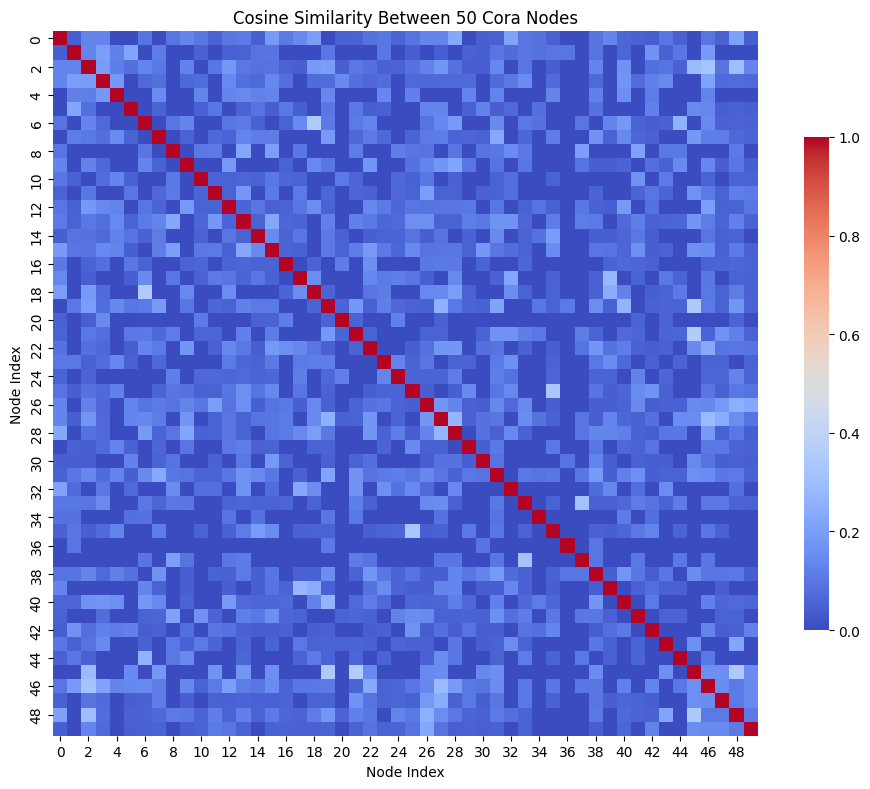

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.datasets import Planetoid
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr

# -------- 1. Load Pubmed dataset --------
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# -------- 2. Get node features --------
features = data.x.cpu().numpy()  # shape: [19717, 500]

# -------- 3. Select 50 random nodes --------
np.random.seed(42)
selected_nodes = np.random.choice(features.shape[0], size=50, replace=False)
selected_features = features[selected_nodes]  # shape: [50, 500]

# -------- 4. Compute node-to-node similarity matrices --------

# 4.1 Cosine Similarity
cosine_sim = cosine_similarity(selected_features)

# 4.2 Pearson Correlation (same as np.corrcoef)
pearson_corr = np.corrcoef(selected_features)

# 4.3 Spearman Correlation
spearman_corr, _ = spearmanr(selected_features, axis=1)

# -------- 5. Plot heatmaps --------
def plot_heatmap(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap='coolwarm', square=True, cbar_kws={"shrink": 0.7})
    plt.title(title)
    plt.xlabel("Node Index")
    plt.ylabel("Node Index")
    plt.tight_layout()
    plt.show()

plot_heatmap(cosine_sim, "Cosine Similarity Between 50 Cora Nodes")
#plot_heatmap(pearson_corr, "Pearson Correlation Between 50 Pubmed Nodes")
#plot_heatmap(spearman_corr, "Spearman Correlation Between 50 Pubmed Nodes")
